In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import brom_functions as bf
import plot_functions as pf

#### Open an initial dataset (observed values)

In [2]:
ds = xr.open_dataset('wadden_sea_out.nc')
df = ds.to_dataframe()
levelcntr = df.groupby('levelcntr').get_group(0.625)
levelface = levelcntr.groupby('levelface').get_group(0)
levelface.describe()

,par,hice,snowthick,icesurft,temperature,salinity,sigma,turbulence,nitrate,silicate,phosphate,oxygen,donflux,gpp,chl_a
count,365.000000,365.0,365.0,365.0,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,35.069321,0.0,0.0,0.0,10.813757,30.490284,23.956172,0.000035,15.759448,10.699419,0.600309,331.889431,1.895625,5.326875,17.024940
std,31.230162,0.0,0.0,0.0,5.574554,0.697100,0.836899,0.000030,13.483072,8.122721,0.375671,47.993865,1.193110,3.352747,8.762977
min,0.074468,0.0,0.0,0.0,2.277187,29.160912,22.598359,0.000009,0.196964,0.885625,0.111622,252.691004,0.210641,0.591919,0.000000
25%,3.119514,0.0,0.0,0.0,5.860116,29.966954,23.212432,0.000018,1.158780,3.862690,0.244642,291.622372,0.706717,1.985937,11.037168
50%,29.455765,0.0,0.0,0.0,10.534888,30.591089,23.889275,0.000025,15.044345,5.976488,0.558698,325.981203,1.895625,5.326875,17.788178
75%,63.477306,0.0,0.0,0.0,16.323988,31.004769,24.501101,0.000040,27.230134,19.984896,0.938452,362.082079,3.084533,8.667813,22.475982
max,100.457275,0.0,0.0,0.0,19.207354,32.490208,26.365789,0.000289,40.905059,25.445419,1.247792,427.340630,3.580609,10.061831,40.770156


In [3]:
par = levelface['par'].values.astype(np.float64)
temperature = levelface['temperature'].values.astype(np.float64)
no3_data = levelface['nitrate'].values.astype(np.float64)
po4_data = levelface['phosphate'].values.astype(np.float64)
si_data = levelface['silicate'].values.astype(np.float64)
o2_data = levelface['oxygen'].values.astype(np.float64)
chl_a = levelface['chl_a'].values.astype(np.float64)
# daily irradiance
irradiance = par*86400/1000000 # convertion microM per second to M per day

#### Parameters

In [4]:
depth = 0.625; k=0.04; latitude=54.88; days = np.arange(0,364,1)

nh4 = np.zeros(365); nh4[0] = 0.1 
no2 = np.zeros(365); no2[0] = 0.1
no3 = np.zeros(365); no3[0] = no3_data[0] 
si = np.zeros(365); si[0] = si_data[0] 
po4 = np.zeros(365); po4[0] = po4_data[0] 
o2 = np.zeros(365); o2[0] = o2_data[0] 

phy = np.zeros(365); phy[0] = 0.1
# daily irradiance, convertion microM per second to M per day
irradiance = par*86400/1000000
knh4_lim=0.5; knox_lim=1; ksi_lim=0.5; kpo4_lim=1; pbm=8; alpha=0.05; kexc=0.015; kmortality=0.1

het = np.zeros(365); het[0] = 0.1
k_het_phy_gro=0.5; k_het_phy_lim=1.1; k_het_pom_gro=0.5; k_het_pom_lim=1.1
k_het_res=0.1; k_het_mort=0.2; uz=0.5; hz=0.5

k_nfix = 0.4; k_nitrif1=0.1; k_nitrif2=0.1; o2s_nf=5; k_anammox=0.8; o2s_dn=10

poml = np.zeros(365); poml[0] = 0.01; pomr = np.zeros(365); pomr[0] = 0.01
doml = np.zeros(365); domr = np.zeros(365)
k_poml_doml=0.15; k_pomr_domr=0.00001; k_omox_o2=1; tref=0
k_doml_ox=0.1; k_poml_ox=0.02; k_domr_ox=0.1; k_pomr_ox=0.002

#### Run simulation

In [5]:
chl_a = bf.calculate(
    depth, k, latitude, 
    days, temperature, 
    nh4, no2, no3, si, po4, o2,
    phy, par, irradiance, 
    knh4_lim, knox_lim, ksi_lim, kpo4_lim, pbm, alpha, kexc, kmortality,
    het, k_het_phy_gro, k_het_phy_lim, k_het_pom_gro, k_het_pom_lim, k_het_res, k_het_mort, uz, hz,
    k_nfix, k_nitrif1, k_nitrif2, o2s_nf, k_anammox, o2s_dn,
    poml, doml, pomr, domr, 
    k_poml_doml, k_pomr_domr, k_omox_o2, tref, k_doml_ox, k_poml_ox, k_domr_ox, k_pomr_ox)

####  $[mM N\,m^{-3}] \cdot \frac{1}{0.01253}$ =  $[mg C\,m^{-3}]$

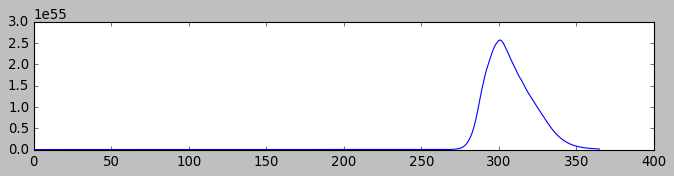

In [6]:
pf.plot_over_year('', '', '', phy)

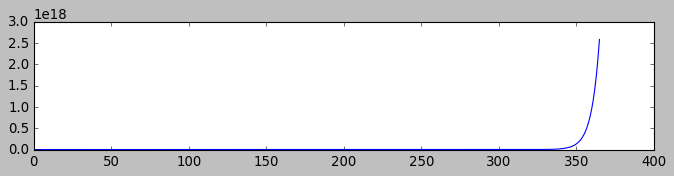

In [7]:
pf.plot_over_year('', '', '', het)

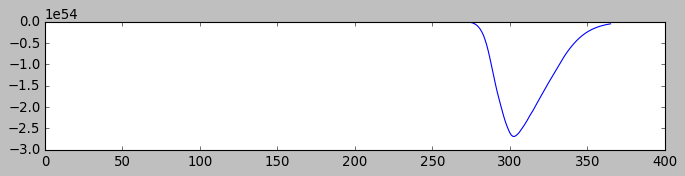

In [8]:
pf.plot_over_year('', '', '', po4)

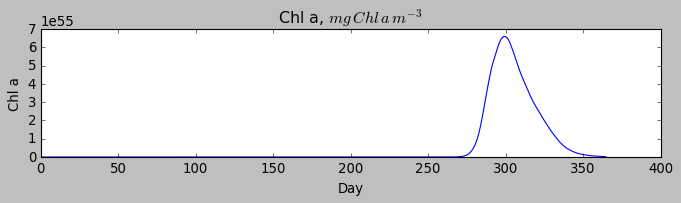

In [9]:
pf.plot_over_year('Day', 'Chl a', 'Chl a, $mg\,Chl\,a\,m^{-3}$', chl_a)